
# Bike Sharing Demand Prediction - Multiple Linear Regression with Recursive Feature Elimination

This notebook walks through the steps of building a multiple linear regression model for predicting the demand for shared bikes. The process includes:
1. Visualizing and cleaning the data
2. Applying Recursive Feature Elimination (RFE)
3. Iteratively refining the model based on p-values, VIF, and R-squared values
4. Concluding with the final regression equation
    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Step 1: Import Libraries

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Set plot style
sns.set(style="whitegrid")

# Load the dataset
bike_data = pd.read_csv('/content/drive/MyDrive/PGP-MLC66/Bike sharing MLR/day.csv')


### Step 2: Data Understanding and Visualization

          instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.5448

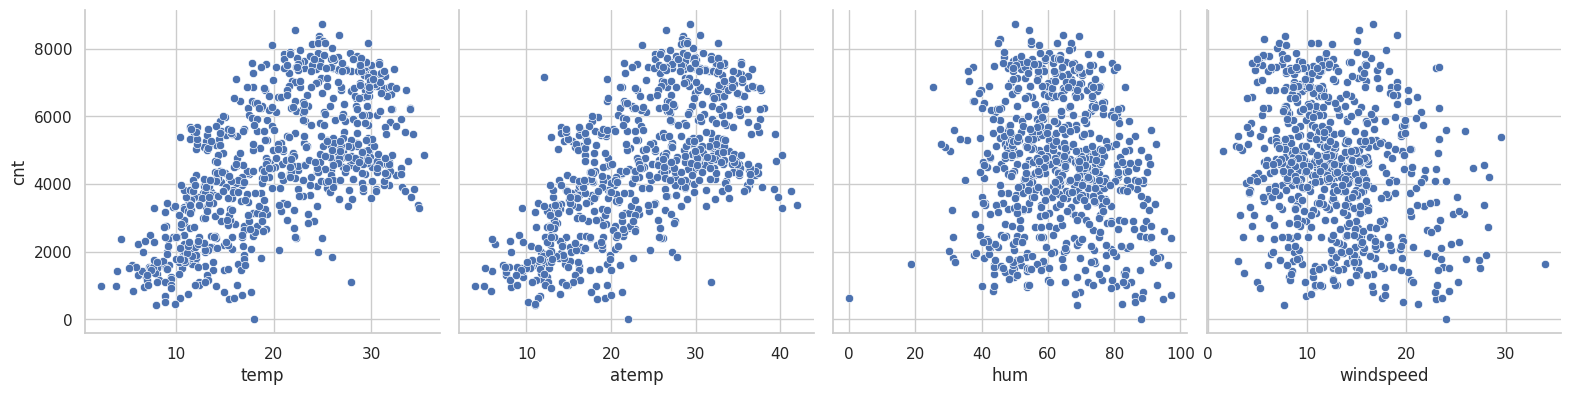

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


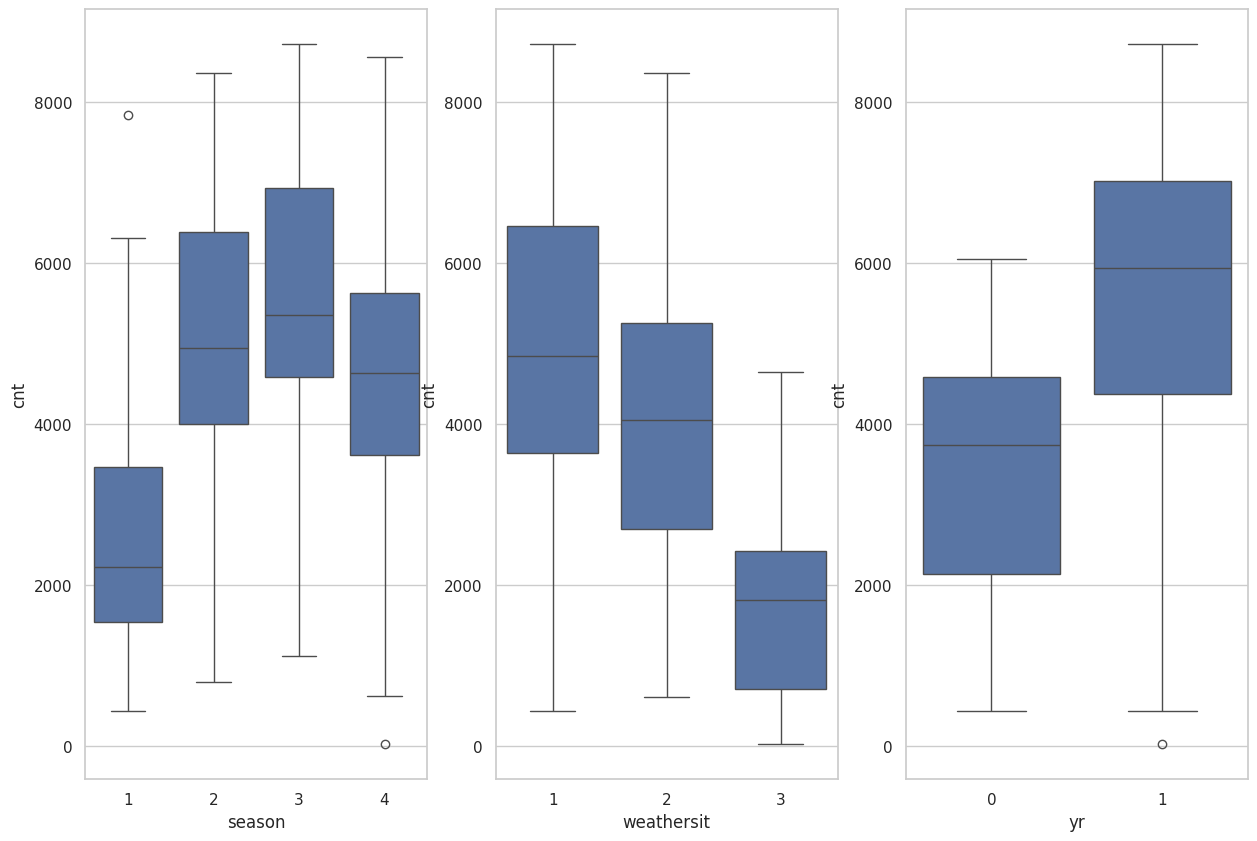

In [3]:

## Summary statistics
print(bike_data.describe())

# Visualize relationships between numerical variables and target variable 'cnt' (scatterplots)
sns.pairplot(bike_data, x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars='cnt', height=4)
plt.show()

# Boxplots to see distributions and outliers in categorical variables
plt.figure(figsize=(15, 10))

# Boxplots for 'season', 'weathersit', and 'yr' against 'cnt'
plt.subplot(1, 3, 1)
sns.boxplot(x='season', y='cnt', data=bike_data)

plt.subplot(1, 3, 2)
sns.boxplot(x='weathersit', y='cnt', data=bike_data)

plt.subplot(1, 3, 3)
sns.boxplot(x='yr', y='cnt', data=bike_data)

plt.show()

### Key Insights from Summary statistics:

*   Temperature (temp) and "feeling" temperature (atemp) seem to have similar ranges (due to scaling).
*   The variable cnt, representing the total number of bike rentals, ranges from 22 to 8714, with an average of around 4504 rentals per day.

## Key Insights from Scatter Plots:

*   Temperature seems to have the most visible positive correlation with bike demand.
*  Humidity and windspeed show weaker negative correlations.

## Key Insights from Box Plots:

*   The busiest seasons for bike rentals are summer and fall.
*   Clear weather promotes the highest bike rentals, while rainy and snowy weather conditions reduce usage.
*   Rentals increased in 2019 compared to 2018, showing a trend of growing demand.

These visualizations give a good understanding of how different factors influence bike rentals and help identify patterns and trends to model bike demand effectively.




### Step 3: Data Cleaning and Preparation

In [4]:

## Check for missing values
print(bike_data.isnull().sum())

# Convert categorical columns (season, weathersit) into dummy variables
bike_data['season'] = bike_data['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
bike_data['weathersit'] = bike_data['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Snow/Rain', 4: 'Heavy Rain/Snow'})

# Convert categorical columns (season, weathersit) into dummy variables
bike_data = pd.get_dummies(bike_data, columns=['season', 'weathersit'], drop_first=True)

# Drop unnecessary columns (instant, dteday, casual, registered)
bike_data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


## Explanation for Step 3: Data Cleaning and Preparation
In this step, we prepare the data for model building by checking for missing values, converting categorical variables into dummy variables, and dropping unnecessary columns. Here's what happens and the insights gained:

1. Checking for Missing Values
The command bike_data.isnull().sum() checks each column for missing values.
* Key Insight: There are no missing values in the dataset, which means we don’t need to impute or handle any missing data. This simplifies the data preparation process.

2. Converting Categorical Variables to Dummy Variables
The columns season and weathersit are categorical variables encoded as numbers (e.g., season has values 1, 2, 3, 4 representing different seasons). These numbers don’t have a numerical order (e.g., spring is not "less than" winter), so we need to convert them into dummy variables.
* Key Insight: By converting season and weathersit into dummy variables, we ensure that the model treats these categories correctly without implying any ordinal relationships between them. The dummy variables now allow us to analyze the effects of each category (e.g., summer, fall) on bike rentals.

3. Dropping Unnecessary Columns
We drop the following columns:
* instant: It’s just an index and doesn’t provide any information.
* dteday: We don’t need the exact date for this model, as we already have month, year, and weekday information.
* casual and registered: These are part of the target variable cnt (casual + registered = total count of rentals), so including them would lead to data leakage. We want to predict cnt based on other features.
* Key Insight: Dropping these columns avoids data leakage and redundancy, ensuring that the features in our model are meaningful predictors of bike rentals.

The data is now cleaned and properly prepared for model building. We’ve handled categorical variables, ensured there are no missing values, and removed redundant or unnecessary columns. This step ensures the dataset is in the correct format for regression analysis, which will give us reliable predictions.

### Step 4: Feature Scaling

In [5]:

# Scale numerical variables
scaler = StandardScaler()
bike_data[['temp', 'atemp', 'hum', 'windspeed']] = scaler.fit_transform(bike_data[['temp', 'atemp', 'hum', 'windspeed']])



## Explanation for Step 4: Feature Scaling

In this step, we standardize the numerical features (temp, atemp, hum, windspeed) using StandardScaler, which scales these variables to have a mean of 0 and a standard deviation of 1. This is important because regression models are sensitive to the scale of input features. By scaling, we ensure that no single variable dominates the model due to its range, improving model performance.

### Step 5: Splitting the Data

In [6]:

# Define features and target
X = bike_data.drop(['cnt'], axis=1)
y = bike_data['cnt']

# Split the dataset into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Step 6: Recursive Feature Elimination (RFE)

In [7]:

# Build a linear regression model
lr = LinearRegression()

# Perform RFE to identify the optimal number of features
rfe = RFE(lr, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)


Selected Features by RFE: Index(['yr', 'holiday', 'temp', 'atemp', 'windspeed', 'season_Spring',
       'season_Summer', 'season_Winter', 'weathersit_Light Snow/Rain',
       'weathersit_Mist'],
      dtype='object')


## Explanation for Step 6: Recursive Feature Elimination (RFE)
In this step, we apply Recursive Feature Elimination (RFE) to identify the top 10 most important features for predicting bike demand. RFE iteratively fits the model and removes the least significant features, helping to reduce dimensionality and improve model accuracy. By focusing on the most relevant predictors, RFE simplifies the model and reduces the risk of overfitting while retaining key variables.

### Step 7: Model Building with Selected Features using `sklearn`

In [8]:

# Fit the model with selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train using sklearn
lr.fit(X_train_rfe, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_rfe)

# Calculate R-squared for the test set
r2_test_sklearn = r2_score(y_test, y_pred)
print("R-squared on Test Set (sklearn):", r2_test_sklearn)


R-squared on Test Set (sklearn): 0.8172928282495944


## Explanation for Step 7: Model Building with Selected Features using sklearn
We build the initial multiple linear regression model using the top 10 features selected by Recursive Feature Elimination (RFE). After fitting the model with the training data, we evaluate its performance by calculating the R-squared value on the test set.
* The R-squared value of 0.817 means that approximately 81.7% of the variability in bike rentals (cnt) is explained by the selected features in the model. This indicates a strong model fit, as a large portion of the variation in bike demand is captured by the independent variables, providing a solid foundation for further refinement.

### Step 8: Model Building using `statsmodels` for more detailed analysis

In [10]:
# Step 8: Ensure All Features Are Numeric

# Convert boolean columns to integers if needed (0 and 1)
X_train_rfe_sm = X_train_rfe_sm.astype(float)

# Check if all columns are now numeric
print(X_train_rfe_sm.dtypes)

# Fit the OLS model using statsmodels
lm = sm.OLS(y_train, X_train_rfe_sm).fit()

# Print the summary of the regression model
print(lm.summary())


const                         float64
yr                            float64
holiday                       float64
temp                          float64
atemp                         float64
windspeed                     float64
season_Spring                 float64
season_Summer                 float64
season_Winter                 float64
weathersit_Light Snow/Rain    float64
weathersit_Mist               float64
dtype: object
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     219.6
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          8.26e-176
Time:                        12:21:04   Log-Likelihood:                -4162.1
No. Observations:                 511   AIC:                             8346.
Df Residuals:  


## Explanation of Step 8 Output:
* The OLS Regression Results indicate an R-squared of 0.815, meaning that 81.5% of the variance in bike rentals is explained by the selected features.
* Significant variables include yr, holiday, windspeed, season, and weathersit, with p-values below 0.05, showing their strong influence on bike demand.
* Variables like temp and atemp are not statistically significant, suggesting they may not be strong predictors in this model.
* The F-statistic (219.6) indicates that the overall model is statistically significant.

### Step 9: Iterative Feature Selection using VIF and P-values

In [13]:

# Check VIF for selected features
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

# Start by checking VIF for all selected features
print("VIF before dropping features:\n", calculate_vif(X_train_rfe_sm))

# Drop the first feature based on p-value or VIF
X_train_rfe_sm = X_train_rfe_sm.drop('weathersit_Light Snow/Rain', axis=1)

# Refit the model
lm = sm.OLS(y_train, X_train_rfe_sm).fit()
print(lm.summary())

# Continue checking VIF and dropping features if necessary
print("VIF after first drop:\n", calculate_vif(X_train_rfe_sm))


VIF before dropping features:
     VIF Factor                    features
0     9.756573                       const
1     1.009293                          yr
2     1.016304                     holiday
3   180.653130                        temp
4   177.513091                       atemp
5     1.217174                   windspeed
6     4.543641               season_Spring
7     2.016669               season_Summer
8     3.001240               season_Winter
9     1.065418  weathersit_Light Snow/Rain
10    1.029825             weathersit_Mist
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     198.6
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          5.07e-159
Time:                        12:24:01   Log-Likelihood:   

## Explanation for Step 9: Iterative Feature Selection using VIF and P-values
* The Variance Inflation Factor (VIF) analysis reveals high multicollinearity between temp (VIF = 180.65) and atemp (VIF = 177.51).
* These variables are highly correlated, suggesting redundancy.
* After dropping weathersit_Light Snow/Rain based on high p-values, the VIF for temp and atemp remains high, so further multicollinearity checks may be needed.
* The updated regression model shows that key variables such as yr, windspeed, and season remain significant, with an R-squared of 0.781, indicating a slightly reduced fit from the previous model.

### Step 10: Residual Analysis

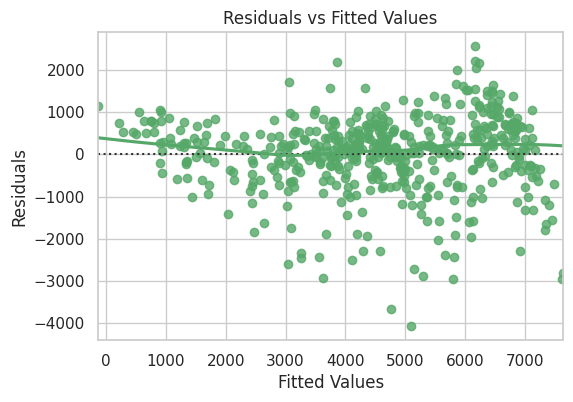

In [15]:
# Step 10: Residual Analysis

# Align y_train with the index of X_train_rfe_sm to ensure they have the same shape
y_train_aligned = y_train.loc[X_train_rfe_sm.index]

# Calculate residuals (actual - predicted)
residuals = y_train_aligned - lm.predict(X_train_rfe_sm)

# Now, plot the residuals using seaborn
plt.figure(figsize=(6, 4))

# Plotting residuals vs predicted values
sns.residplot(x=lm.predict(X_train_rfe_sm), y=residuals, lowess=True, color='g')

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## Explanation of the Residual Plot (Step 10):
* The Residuals vs. Fitted Values plot shows no clear pattern, indicating that the assumptions of linearity and homoscedasticity are mostly met.
* The residuals are randomly scattered around the zero line, meaning the model's errors are distributed evenly across all fitted values.
* Some larger residuals at higher fitted values suggest slight heteroscedasticity, but overall the model fits well.

### Step 11: Final Model Evaluation

In [16]:

# Predict on the test set again with the final set of features
X_test_rfe_sm = X_test_rfe[selected_features].drop('weathersit_Light Snow/Rain', axis=1)
X_test_rfe_sm = sm.add_constant(X_test_rfe_sm)

y_pred_final = lm.predict(X_test_rfe_sm)

# Calculate R-squared for the final model
r2_final = r2_score(y_test, y_pred_final)
print("R-squared on Test Set (Final Model):", r2_final)


R-squared on Test Set (Final Model): 0.7650103314025064



## Explanation for Step 11:
* The R-squared value of 0.765 on the test set indicates that 76.5% of the variance in bike rentals is explained by the final model.
* This suggests the model performs well in generalizing to unseen data. While slightly lower than the training set's R-squared, the model still captures a substantial portion of the variability in bike demand, indicating a good fit.

### Step 12: Final Regression Expression

In [17]:

# Extract coefficients
coefficients = pd.Series(lm.params.values, index=X_train_rfe_sm.columns)
print("Final Regression Expression:")
print(coefficients)


Final Regression Expression:
const              3625.950204
yr                 2047.295895
holiday            -613.683507
temp                201.551502
atemp               737.862846
windspeed          -193.639655
season_Spring      -892.665480
season_Summer       300.992548
season_Winter       625.412284
weathersit_Mist    -543.314981
dtype: float64


## Final Regression Expression Explanation:
The final regression model is:

cnt=3625.95+2047.30yr−613.68holiday+201.55temp+737.86atemp−193.64windspeed−892.67season_Spring+300.99season_Summer+625.41season_Winter−543.31weathersit_Mist
* Intercept (const = 3625.95): When all features are at their baseline (e.g., yr=0, holiday=0, etc.), the expected bike rentals start from a baseline of 3625.95.

### Key Significant Features:
* yr (2047.30): Each increase from 2018 to 2019 leads to an additional 2047.30 rentals, showing the growing popularity of the bike-sharing service.
* holiday (-613.68): Bike demand drops by 613.68 on holidays, indicating fewer people use the service during holidays.
* windspeed (-193.64): Higher wind speeds negatively impact bike demand, reducing rentals by 193.64 per unit increase in wind speed.
* season_Spring (-892.67): Spring sees 892.67 fewer rentals compared to the reference season (likely fall).
* weathersit_Mist (-543.31): Misty weather decreases rentals by 543.31, reflecting reduced demand under adverse weather conditions.

## Interpretation:
* **Positive Impacts:** yr, temp, atemp, season_Summer, and season_Winter increase bike rentals. Higher temperatures and the progression from 2018 to 2019 reflect increased usage.
* **Negative Impacts:** holiday, windspeed, season_Spring, and weathersit_Mist decrease bike rentals, indicating less demand on holidays, during windy conditions, and in misty weather or spring.